## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [11]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2021-12-20 14:23:46--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.01s   

2021-12-20 14:23:46 (7.91 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# # Your great code here
out = set()
for s in text:
  out.update(set(s))

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(out))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
id_to_token = {idx: char for char, idx in enumerate(tokens)}
# dict <char>:<index>
# Your great code here
token_to_id = {char: idx for idx, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [8]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
import torch, torch.nn as nn
import time
from torch.optim import lr_scheduler, Adam
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
from random import sample
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


class CharRNNCell(nn.Module):
    
    def __init__(self, num_tokens=len(token_to_id), embedding_size=100, rnn_num_units=200):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units     
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.activation = nn.PReLU(num_parameters=self.num_units)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = self.rnn_update(x_and_h)    
        h_next = self.activation(h_next)
        logits = self.rnn_to_logits(h_next)    
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.randn(batch_size, self.num_units, requires_grad=True).to(device)

def to_matrix(tok_to_id, text, samples_num=5000, batch_len=300):
    
    return torch.tensor([[tok_to_id[tok] for tok in text[start:start+batch_len]]
            for start in torch.randint(0, len(text) - batch_len, (samples_num,))]).to(device)

def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []
    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  
        logprobs.append(logp_next)      
    return torch.stack(logprobs, dim=1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=100): 
    since = time.time()
    model.to(device)
    model.train() 
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs in dataloader:        
            inputs = inputs.to(device)           
            optimizer.zero_grad()
            logp_seq = rnn_loop(model, inputs)
            logp_next = torch.gather(logp_seq[:, :-1], dim=2, index=inputs[:, 1:][:,:,None])
            loss = -logp_next.mean()
            loss.backward()          
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss
        scheduler.step()
        epoch_loss = running_loss / len(dataloader)
        losses.append(epoch_loss)
        clear_output(True)
        plt.plot(losses, label='current loss: {:.2}'.format(epoch_loss))
        plt.legend()
        plt.show()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))   
    return model, losses

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
batch_size = 200
model = CharRNNCell()
dataloader = DataLoader(to_matrix(token_to_id, text), batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.7)

In [ ]:
# Your plot code here

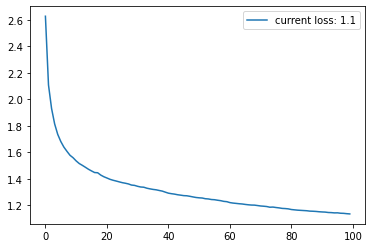

Training complete in 34m 3s


In [10]:
model, losses = train_model(model, criterion, optimizer, scheduler)

In [35]:
MAX_LENGTH=500

def generate_sample(char_rnn, seed_phrase=' Hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
    hid_state = char_rnn.initial_state(batch_size=1)
    char_rnn.eval()
    
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(token_to_id), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

In [41]:
print(generate_sample(model, seed_phrase='hello my friends, i want to say that ', 
                      max_length=500, temperature=0.3))

hello my friends, i want to say that thou shalt not love that shall be thee thou will be the true substance of thy self thou mayst then the stare the world me with thee,
  when i am seeming on the world that thou shalt strange shall beauty still the world to see then she love, the world with thee is not so race my love, that thou mayst the tonguest of the shorn the beauty shall beauty by this this thou art more worddless self to be more the state more blame thee shall state,
    and to the world


In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hello my friends, i want to say that the truth's lose, then happy i show, when the give the self thou days are of diest the merit the may,
    that thou best be the time more love's first, and shall not farther than your was not spend.
  now sing thou art the strangely be the sweet that shall be that so it suberre that thy self as ext'st thou the comment, and love and thee,
  though the stall where where the the will be grow
  to his abling pend,
  and so should leven the leaves in thy self is b

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [45]:
# Your beautiful code here
class LSTM(nn.Module):
    
    def __init__(self, num_tokens=len(token_to_id), embedding_size=100, rnn_num_units=200):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)      
        self.lstm = nn.LSTMCell(embedding_size, rnn_num_units)
        self.fc = nn.Linear(in_features=rnn_num_units, out_features=len(token_to_id))
        
    def forward(self, x, h_prev, c_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x)
        h, c = self.lstm(x_emb, (h_prev, c_prev))       
        output = self.fc(h)      
        return h, c, F.log_softmax(output, -1)
    
    def initial_state(self, batch_size):
        return torch.randn(batch_size, self.num_units, requires_grad=True).to(device), \
               torch.randn(batch_size, self.num_units, requires_grad=True).to(device)


def lstm_loop(model, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state, cell_state = model.initial_state(batch_size)
    logprobs = []
    for x_t in batch_ix.transpose(0, 1):
        hid_state, cell_state, logp_next = model(x_t, hid_state, cell_state)  
        logprobs.append(logp_next)      
    return torch.stack(logprobs, dim=1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=50):  
    since = time.time()
    model.to(device)
    model.train()   
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs in dataloader:         
            inputs = inputs.to(device)         
            optimizer.zero_grad()
            logp_seq = lstm_loop(model, inputs)
            predictions_logp = logp_seq[:, :-1]
            actual_next_tokens = inputs[:, 1:]
            logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])
            loss = -logp_next.mean()
            loss.backward()         
            optimizer.step()
            optimizer.zero_grad()
            running_loss += loss
        scheduler.step()
        epoch_loss = running_loss / len(dataloader)
        losses.append(epoch_loss)
        clear_output(True)
        plt.plot(losses, label='current loss: {:.2}'.format(epoch_loss))
        plt.legend()
        plt.show()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) 
    return model, losses


model = LSTM()
dataloader = DataLoader(to_matrix(token_to_id, text), batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-1, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

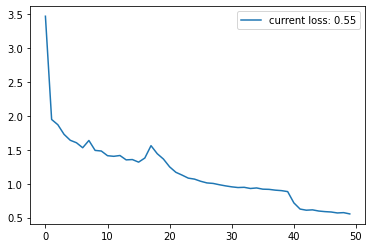

Training complete in 50m 22s


In [46]:
model, losses = train_model(model, criterion, optimizer, scheduler)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [51]:
# Text generation with different temperature values here
def generate_text(model, init=' Poor soul', length=256, temperature=1.0):

    x_sequence = [token_to_id[token] for token in init]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64, device=device)
    hid_state, cell_state = model.initial_state(batch_size=1)
    model.eval()
    for i in range(len(init) - 1):
        hid_state, cell_state, _ = model(x_sequence[:, i], hid_state, cell_state)
    for _ in range(length - len(init)):
        hid_state, cell_state, logp_next = model(x_sequence[:, -1], hid_state, cell_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.cpu().numpy()[0]      
        next_ix = np.random.choice(len(token_to_id), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64, device=device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)    
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0]])

print("Generated texts:")

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(generate_text(model, init="let's see", length=100, temperature=temp))
    print("-"*20)

Generated texts:
let's seeing that is told.

  lxxxvii

  when thou shalt be dispos'd to set me light,
  and pays it 
--------------------
let's seet doth bear and hopour posterity.
    then after thou wilt; being your sweet dost doth give
--------------------
let's seeing,
  for i am so preposterity not better for my love thou spend
  shine on me the conque;
--------------------
let's seeing,
  and for a appear it myself miturn true,
  myself, not bone, be you a ttoft dee,
    
--------------------
let's seekveno' gren,
  no more be betth'',r epna,nce, fo((time
  resee ,and' seet herxr gel;y wnx?

--------------------


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [52]:
# Saving and loading code here
'link with example does not work('

torch.save(model, 'my_model')

In [53]:
model = torch.load('my_model')

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)